# The BeachDuneManager module: beach and dune management for coastal communities in CASCADE

In this notebook we illustrate the functionality of the BeachDuneManager module within `CASCADE`. In the BeachDuneManager module, we incorporate beach nourishment and dune management strategies to maintain a coastal community at a fixed cross-shore position. Specifically, we: 
- Widen the beach via nourishment of the shoreface
- Nourish dunes or rebuild following storms
- Remove overwash to account for the filtering effect of development on overwash deposition (Rogers et al., 2015) and place it back on the shoreface
- Remove overwash to account for bulldozing and place back on the adjacent dunes

These management strategies are employed until the barrier reaches a minimum width and can no longer sustain a community, here defined as the combined width of a single roadway and building footprint (50 m). Thereafter, the community is abandoned and the barrier is allowed to evolve in accordance with the rules and dynamics in Barrier3D. 

For a complete description of the dynamics in the BeachDuneManager module, we direct the user to Anarde et al., (). Here, we seek only to hold your hand and walk you through use of the BeachDuneManager.      

When initializing the BeachDuneManager, the following variables can be specified by the user, with the default values shown below:
```
        - nourishment_interval: None
            Interval that nourishment occurs [yrs]
        - nourishment_volume: 100
            Volume of nourished sand along cross-shore transect [m^3/m]
        - initial_beach_width: 30
            Initial beach width [m]
        - dune_design_elevation: 3.7
            Elevation to which dune is rebuilt to [m MHW]; does not change with RSLR.
        - time_step_count: 500
            Number of time steps.
        - original_growth_param: None
            Dune growth parameters from first time step of barrier3d, before human modifications [unitless]
        - overwash_filter: 40
            Percent overwash removed from barrier interior and placed back on the shoreface
            [40-90% (residential-->commercial) from Rogers et al., 2015]
        - overwash_to_dune: 10
            Percent overwash removed from barrier interior to dunes [%, overwash_filter+overwash_to_dune <=100]
``` 
Note that when the BeachDuneManager is initialized in `CASCADE`, the initial beach width is calculated based on the user supplied slope and berm elevation.

In the examples below, we initialize `CASCADE` with the default wave climate and dune dynamics (average dune growth rate of 0.45), but increase the rate of sea level rise to 0.007 m/yr and simulate only one 500 m `Barrier3D` domain. All other optional modules are turned off (alongshore sediment transport from `BRIE`, community dynamics from `CHOM`, and roadway management). 

In [3]:
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# sys.path.extend(['/Users/KatherineAnardeWheels/PycharmProjects/Barrier3D', '/Users/KatherineAnardeWheels/PycharmProjects/brie', '/Users/KatherineAnardeWheels/PycharmProjects/CASCADE'])
datadir = "../cascade/data/" 
Path(datadir)
notebook_dir = "../notebooks/"

from cascade import Cascade
from chom import Chom
from cascade.tools import plotters as cascade_plt

## OPTION 1: Nourishment and dune rebuilding at discrete intervals

In this first example, we start by nourishing one Barrier3D domain at discrete intervals, here every 10 years, with a nourishment volume of 100 $m^3/m$, which for the default shoreface and barrier configuration produces about 20 m of shoreline progradation. We do this for 50 years and then change to a 20 year nourishment interval with 300 $m^3/m$ of nourishment volume. We specify that 40% of overwash is filtered by development (residential, Rogers et al., 2015) and 10% of the overwash that is deposited is removed and placed on adjacent dunes -- see the notebook BeachDuneManager-Overwash_Sensitivity for more details.

**Note that when specifying nourishment at discrete intervals, both the shoreface AND the dune are nourished.**

In [4]:
option1_name= "nourishment_intervals"
iB3D = 0
total_time = 100

cascade = Cascade(
    datadir,
    name=option1_name,
    sea_level_rise_rate=0.007,
    alongshore_section_count=1,
    time_step_count=total_time,
    num_cores=1,
    roadway_management_module=False,
    alongshore_transport_module=False,
    beach_nourishment_module=True,
    community_economics_module=False,
    dune_design_elevation=3.7,  
    nourishment_interval=10,  # yrs
    nourishment_volume=100, 
    background_erosion=-1.0, # m/yr
    overwash_filter=40,
    overwash_to_dune=10,
)


# Loop for 50 years at a 10 year interval, 100 m^3/m and then 50 years at a 20 year interval with 300 m^3/m
nt = 50
for _ in tqdm(range(nt-1)):
    cascade.update()
    if cascade.b3d_break:
        break
        
# during the CASCADE initialization, the nourishment interval and volume is specified individually for each 
# barrier3d alongshore cell; so to update these values, we need to specify which barrier3d cell we want to modify
# (here, we only have one cell)
cascade.nourishment_interval[iB3D] = 20  # increase to 20 years
cascade.nourishment_volume[iB3D] = 300  # increase to 300 m^3/m

for _ in tqdm(range(nt)):
    cascade.update()
    if cascade.b3d_break:
        break

100%|██████████| 50/50 [00:09<00:00,  5.48it/s]


Text(0.5, 1.0, 'Profile evolution after nourishment')

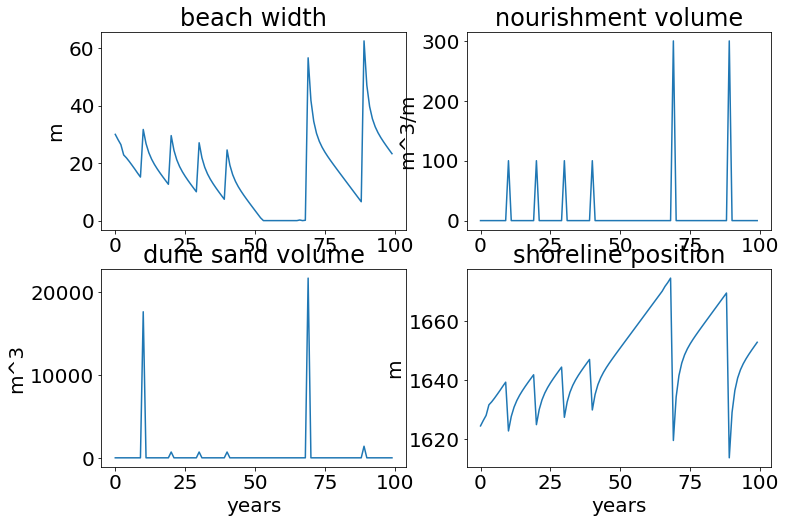

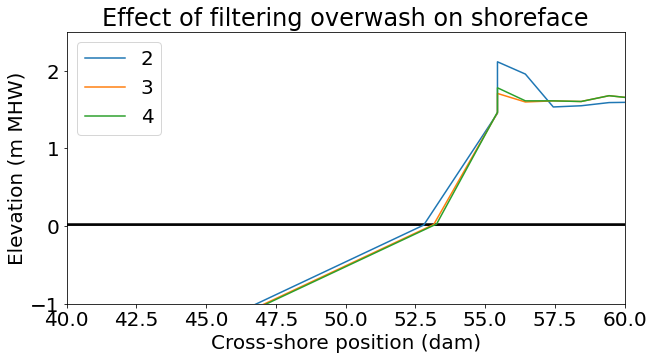

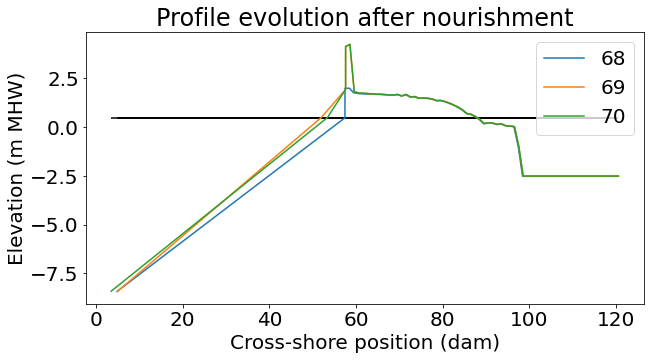

In [7]:
fig=plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(cascade.nourishments[iB3D].beach_width)
plt.title("beach width")
plt.ylabel("m")

plt.subplot(2,2,2)
plt.plot(cascade.nourishments[iB3D]._nourishment_volume_TS)
plt.title("nourishment volume")
plt.ylabel("m^3/m")

plt.subplot(2,2,3)
plt.plot(cascade.nourishments[iB3D]._rebuild_dune_volume_TS)
plt.title("dune sand volume")
plt.ylabel("m^3")
plt.xlabel("years")

plt.subplot(2,2,4)
plt.plot(np.array(cascade.barrier3d[iB3D]._x_s_TS) * 10)
plt.title("shoreline position")
plt.ylabel("m")
plt.xlabel("years")

time_step = [2, 3, 4, 68, 69, 70]
fig = cascade_plt.plot_ModelTransects(cascade, time_step[0:3], iB3D=0)
fig.set_title("Effect of filtering overwash on shoreface")
fig.set_xlim([40,60])
fig.set_ylim([-1,2.5])
fig2 = cascade_plt.plot_ModelTransects(cascade, time_step[3:6], iB3D=0)
fig2.set_title("Profile evolution after nourishment")

In [ ]:
time_step = [68,69]
sea_level = cascade.barrier3d[iB3D]._SL  # always zero
y_shoreline = 0  # also doesn't change
# y_shoreface = (sea_level - cascade.barrier3d[iB3D].DShoreface) * 10  # also doesn't change
x_shoreface = np.array(cascade.barrier3d[iB3D]._x_t_TS) * 10
x_shoreline = np.array(cascade.barrier3d[iB3D]._x_s_TS) * 10
# y_shoreline = sea_level
y_shoreface = cascade.barrier3d[iB3D].DShoreface * 10

area_pre_nourish = np.trapz([y_shoreface,y_shoreline], x=[x_shoreface[time_step[0]], x_shoreline[time_step[0]]])
area_post_nourish = np.trapz([y_shoreface,y_shoreline], x=[x_shoreface[time_step[1]], x_shoreline[time_step[1]]])
area_pre_nourish-area_post_nourish

Now that I've integrated, I'm not sure what it tells us other than the area of the wedge...bleh. Ignore.

In the time series figures above, we see that nourishment in the first 50 years (every 10 years at 100 $m^3/m$) cannot keep up with shoreline erosion, which in this simulation includes that from 0.007 m/yr of sea level rise and from 1 m/yr of background erosion. Note that while we allow the beach width to reach zero, an unrealistic phenonmenon, this only implies in the CASCADE framework that dune migration is turned back on and the island is allowed to transgress landward. We can see these dynamics in planform view with the built-in gif plotter:

In [ ]:
cascade_plt.plot_ElevAnimation_Humans_BeachDuneManager(
    cascade, ny=1, directory=notebook_dir, TMAX=99, name=option1_name, TMAX_SIM=100)

In [ ]:
gif_dir = notebook_dir + "Output/" + option1_name + "/SimFrames/"
Path(gif_dir)

![SegmentLocal](../notebooks/Output/nourishment_intervals/SimFrames/elev.gif "segment")

As shown in the gif plotter, we plot an intermediate "0.5 year" timestep, which corresponds to the post-storm barrier configuration *BEFORE* we employ beach and dune management in the BeachDuneManager. These variables are saved to the nourishment module and all begin with "post_storm...". For example, the value for `nourishments[iB3D].post_storm_beach_width[2]` corresponds to the post storm beach width prior to any nourishment decisions during year 2 (i.e., year 1.5). Every variable that is saved to the 1-yr time step in Barrier3D reflects modifications by human management decisions. 

Note that in the above plotter, each cell corresponds to a decameter and therefore the shoreline position and beach widths are rounded and not representative of the actual shoreline position and beach width (however, the evolution of the shoreline and dune migration is correct). We can use another built-in plotter below to view relevant statistics that include the "0.5 year" time step -- including the actual beach width, shoreline position, and dune toe location. This plotter is also particularly insightful for how barrier width, height, and overwash fluxes are altered by our management decisions.

In [ ]:
    (
        BarrierWidth,
        DuneCrestMean,
        BarrierHeight,
        bh_rate,
        bw_rate,
        sc_rate,
        DuneCrestMin,
        DuneCrestMax,
        shoreline_position,
        shoreface_slope,
        beach_width,
        overwash,
        dune_toe
    ) = cascade_plt.plot_nonlinear_stats_BeachDuneManager(
        cascade.barrier3d,
        iB3D,
        tmax_management=100,
        tmax_sim=100,
        nourishments=cascade.nourishments,
        post_storm_dunes=cascade.nourishments[iB3D]._post_storm_dunes,
        post_storm_x_s=cascade.nourishments[iB3D]._post_storm_x_s,
        post_storm_s_sf=cascade.nourishments[iB3D]._post_storm_s_sf,
        post_storm_ave_interior_width=cascade.nourishments[iB3D]._post_storm_ave_interior_width,
        post_storm_ave_interior_height=cascade.nourishments[iB3D]._post_storm_ave_interior_height,
        post_storm_beach_width=cascade.nourishments[iB3D]._post_storm_beach_width,
        post_storm_Qow=cascade.nourishments[iB3D]._post_storm_Qow,
        design_elevation=cascade.nourishments[iB3D]._dune_design_elevation,  # m MHW,
        rebuild_threshold=None,
        dunes_rebuilt=cascade.nourishments[iB3D]._dunes_rebuilt_TS,
    )

The dune dynamics at first glance seem pretty wacky, but if we look at individual figures as part of the gif, we can see that the first line of the dune gets eroded at 57.5 years and the second at 64.5 years, leaving a small foredune, growing at a low rate. The dunes are not rebuilt until the next nourishment at 69 years.

As a check on the dynamics in Barrier3D, here we want to see if the dunes migrate when the beach width goes to zero and the shoreline surpasses a full cell width (10 m). Indeed, dunes only migrate when humans allow them to (beach width = 0), and when the shoreline moves a full cell width -- in year 58 and 65. Note that if one was to check the `post_storm_x_s`, they would find that the dunes actually migrated at 57.5 since dune migration occurrs prior to any human modifications.

In [ ]:
frac_grid_cell = np.array(cascade.barrier3d[iB3D]._x_s_TS) % 1
diff = np.hstack([0,np.diff(frac_grid_cell)])
diff[~np.array(cascade.nourishments[iB3D]._dune_migration_on)] = 0
shoreline_transgressed = diff < 0 
dunes_migrated = cascade.barrier3d[iB3D]._ShorelineChangeTS < 0
print("Indices for when dunes migrated = ", np.where(dunes_migrated)[0])
print("Indices for when shoreline transgressed = ", np.where(shoreline_transgressed)[0])
# shoreline_transgressed == dunes_migrated  # for pytest

## OPTION 2: Nourishment and dune rebuilding based on user indicators

The second option for shoreface nourishment and dune rebuilding is based on user supplied indicators. Here, we trigger nourishment using the `nourish_now` parameter after the beach width reaches a minimum beach width (30 m). The dune is rebuilt using the `rebuild_dune_now` parameter only when the dune is knocked down (by storms) to a minimum dune height (here, 0.3 m above the berm elevation). Recall that a percentage of overwash can also be removed and added to the adjacent dunes after storms up to a maximum height. Here, we also show what it looks like after a community has been abandoned -- that is, after it narrows to a point that it can no longer sustain a community. This option is that which was used in the "Pathways to barrier drowning arising from coastal management practices".

In [ ]:
datadir = "../../../../cascade/data/pathways_data/"  # laptop 
Path(datadir)

In [2]:
iB3D = 0
total_time = 300

cascade = Cascade(
    datadir,
    name="nourish_now_test",
    sea_level_rise_rate=0.007,
    alongshore_section_count=1,
    time_step_count=total_time,
    num_cores=1,
    roadway_management_module=False,
    alongshore_transport_module=False,
    beach_nourishment_module=True,
    community_economics_module=False,
    dune_design_elevation=3.7,  # dune rebuilt to this height when specified
    nourishment_interval=None,  # yrs
    nourishment_volume=100,  # m^3/m 
    background_erosion=-1.0, # m/yr
    overwash_filter=90,
    overwash_to_dune=10,
)
    
# loop for 200 years, but after each year, check the beach width and dune height and decide if you want to nourish
# or rebuild dune the next year with trigger parameter
bw_threshold = 30  
dune_threshold = 0.3 + (
        cascade.barrier3d[iB3D].BermEl * 10
    )  # same threshold for absolute minimum elevation as in RoadwayManager (m MHW)

for _ in tqdm(range(total_time-1)):
    cascade.update()
    if cascade.b3d_break:
        break

    # stop managing if the barrier becomes too narrow to sustain a community
    if cascade.community_break:
        pass
    else:
        t = cascade.barrier3d[iB3D].time_index

        if cascade.nourishments[iB3D].beach_width[t - 1] < bw_threshold:
            cascade.nourish_now[iB3D] = 1

        DuneDomainCrest = (
            cascade.barrier3d[iB3D].DuneDomain[t - 1, :, :].max(axis=1)
        )  # Maximum height of each row in dune domain [dam]
        DuneCrestMin = (
            np.min(DuneDomainCrest) + cascade.barrier3d[iB3D].BermEl
        ) * 10  # m MHW

        if DuneCrestMin < dune_threshold:
            cascade.rebuild_dune_now[iB3D] = 1

 64%|██████▍   | 192/299 [01:17<00:36,  2.89it/s]/Users/KatherineAnardeWheels/PycharmProjects/Barrier3D/barrier3d/barrier3d.py:1497: RuntimeWarning: invalid value encountered in double_scalars
  Qs1 = Qs0 * Q1 / (Q1 + Q2 + Q3)
/Users/KatherineAnardeWheels/PycharmProjects/Barrier3D/barrier3d/barrier3d.py:1498: RuntimeWarning: invalid value encountered in double_scalars
  Qs2 = Qs0 * Q2 / (Q1 + Q2 + Q3)
/Users/KatherineAnardeWheels/PycharmProjects/Barrier3D/barrier3d/barrier3d.py:1499: RuntimeWarning: invalid value encountered in double_scalars
  Qs3 = Qs0 * Q3 / (Q1 + Q2 + Q3)
 75%|███████▍  | 224/299 [03:20<00:25,  2.97it/s]

Community reached minimum width, drowned at 224 years


100%|██████████| 299/299 [12:56<00:00,  2.60s/it]


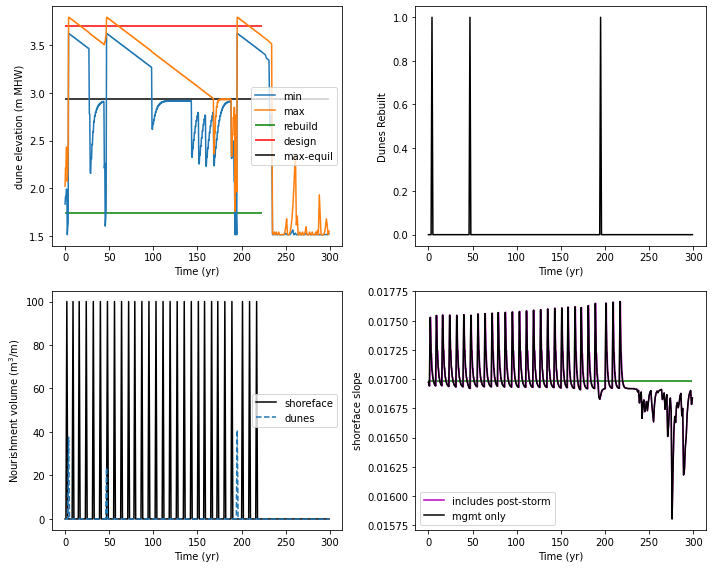

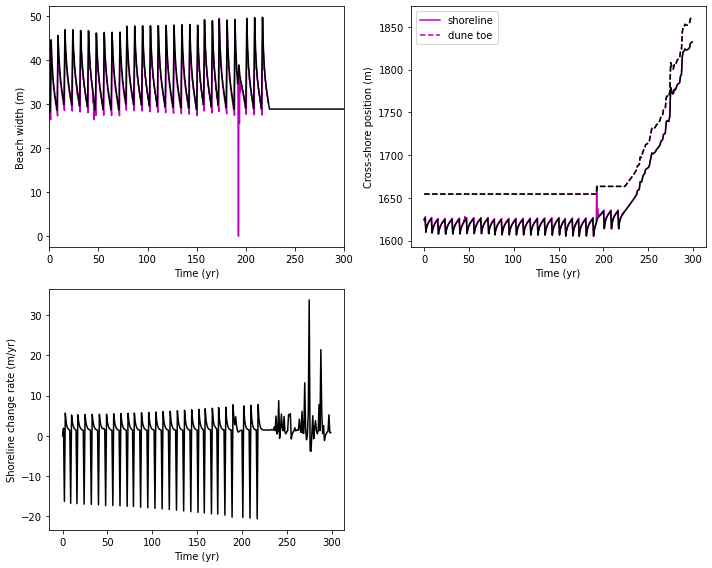

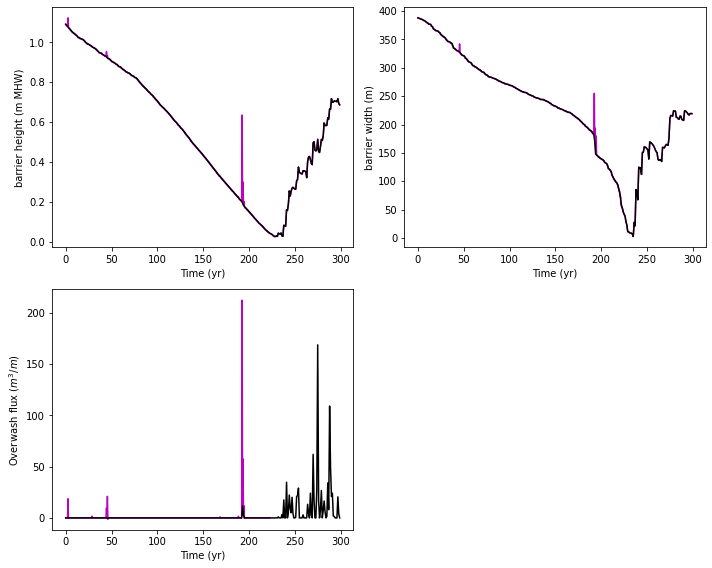

In [3]:
    (
        BarrierWidth,
        DuneCrestMean,
        BarrierHeight,
        bh_rate,
        bw_rate,
        sc_rate,
        DuneCrestMin,
        DuneCrestMax,
        shoreline_position,
        shoreface_slope,
        beach_width,
        dune_toe,
        overwash,
    ) = cascade_plt.plot_nonlinear_stats_BeachDuneManager(
        cascade.barrier3d,
        iB3D,
        tmax_management=224,
        tmax_sim=300,
        nourishments=cascade.nourishments,
        post_storm_dunes=cascade.nourishments[iB3D]._post_storm_dunes,
        post_storm_x_s=cascade.nourishments[iB3D]._post_storm_x_s,
        post_storm_s_sf=cascade.nourishments[iB3D]._post_storm_s_sf,
        post_storm_ave_interior_width=cascade.nourishments[iB3D]._post_storm_ave_interior_width,
        post_storm_ave_interior_height=cascade.nourishments[iB3D]._post_storm_ave_interior_height,
        post_storm_beach_width=cascade.nourishments[iB3D]._post_storm_beach_width,
        post_storm_Qow=cascade.nourishments[iB3D]._post_storm_Qow,
        design_elevation=cascade.nourishments[iB3D]._dune_design_elevation,  # m MHW,
        rebuild_threshold=dune_threshold,
        dunes_rebuilt=cascade.nourishments[iB3D]._dunes_rebuilt_TS,
    )

## OPTION 3: Nourishment and dune rebuilding based on CHOM (community dynamics)

The last option for shoreface nourishment and dune rebuilding is based on coupling with the Coastal Home Ownership Model (CHOM). CHOM receives information about the coastal environment and acts on that information to cause change to the environment, including decisions about beach nourishment and dune construction and maintenance. Similar to Option 2 described above, when coupled to CHOM, we nourish using the the `nourish_now` parameter after agents in CHOM decide to nourish based on environmental parameters. Here, the `nourishment_volume` is also specified by the community agents in CHOM. In CHOM, the beach width can fall to zero. If this happens, dune migration is turned back on in Barrier3D and the first line of homes can potenitally be eaten up by storms. 

Dunes are also rebuilt using the `rebuild_dune_now` parameter, when specified by agents  in CHOM. In CHOM, the dune height can fall to zero. 

Because coupling with CHOM requires the BeachDuneManager -- CHOM is called first, then the BeachDuneManager -- we can also account for the filtering effect of residential and commercial properties, and remove overwash and place back on the dune.

In the example below, we simulate the evolution of one community that spans 4 Barrier3D models (3 km)

In [ ]:
datadir = "../../../../cascade/data/pathways_data/"  # laptop 
Path(datadir)

In [ ]:
total_time = 50
cascade = Cascade(
    datadir,
    name="chom_coupling_test",
    parameter_file="RUN10-CASCADE-parameters.yaml",
    sea_level_rise_rate=0.007,
    alongshore_section_count=6,  
    time_step_count=total_time,
    num_cores=6,
    roadway_management_module=False,
    alongshore_transport_module=True,
    beach_nourishment_module=True,
    community_economics_module=True,
    dune_design_elevation=3.7, 
    nourishment_interval=None,  
    nourishment_volume=100,  # set by CHOM, dummy variable
    number_of_communities=1, 
    sand_cost=10,
    taxratio_oceanfront=3,
    external_housing_market_value_oceanfront=6e5,
    external_housing_market_value_nonoceanfront=4e5,
    fixed_cost_beach_nourishment=1e6,
    fixed_cost_dune_nourishment=1e5,
    nourishment_cost_subsidy=0.9125,
    house_footprint_x=15,
    house_footprint_y=20,
    beach_full_cross_shore=70
)

# Loop for 100 years 
for _ in tqdm(range(total_time-1)):
    cascade.update()
    if cascade.b3d_break:
        break

Now, let's compare this run with just CHOM (no CASCADE coupling) for the same (approximately) initial conditions). Note the variables below ... are the default parameters for the coupled simulation above. I just listed them here for completeness (and debugging).

In [ ]:
total_time=50

chom = Chom(
    name="chom_test",
    total_time=total_time,
    average_interior_width=388.2,  # default is 300
    barrier_island_height=1.09,  # 1
    beach_width=30.0,  # None
    dune_height=0.4977,  # None
    shoreface_depth=8.9,  # 10
    dune_width=20.0,  # 25
    dune_height_build=2.26,  # 4
    shoreline_retreat_rate=0.268,  # coupled is zero, default is 1 *** I took this from t=1 in the coupled model, ask Zach
    alongshore_domain_extent=3000,  # ------- all variables below are default (same as in coupled) --------
    sand_cost=10,
    taxratio_oceanfront=3,
    external_housing_market_value_oceanfront=6e5,
    external_housing_market_value_nonoceanfront=4e5,
    fixed_cost_beach_nourishment=1e6,
    fixed_cost_dune_nourishment=1e5,
    nourishment_cost_subsidy=0.9125,
    house_footprint_x=15,
    house_footprint_y=20,
    beach_full_cross_shore=70,
    agent_expectations_time_horizon=30,  # ------- these are also default (but we don't allow you to change them in CASCADE) --------
    agent_erosion_update_weight=0.5,
    beach_width_beta_oceanfront=0.25,
    beach_width_beta_nonoceanfront=0.15,
    discount_rate=0.06,
    nourishment_plan_loan_amortization_length=5,
    nourishment_plan_time_commitment=10,
)

# Loop through time until the inevitable happens
for _ in tqdm(range(total_time-1)):
    chom.update()

In [ ]:
fig=plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(cascade.nourishments[iB3D].beach_width)
plt.title("beach width")
plt.ylabel("m")

plt.subplot(2,2,2)
plt.plot(cascade.nourishments[iB3D]._nourishment_volume_TS)
plt.title("nourishment volume")
plt.ylabel("m^3/m")
plt.xlabel("years")

plt.subplot(2,2,3)
plt.plot(cascade.nourishments[iB3D]._rebuild_dune_volume_TS)
plt.title("dune sand volume")
plt.ylabel("m^3")
plt.xlabel("years")
fig.tight_layout()